Continuation of 05th Notebook

In [1]:
# ----------------------------------------------------
# Adaptive Allocation Backtest using Regime-based Weights
# ----------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# -------------------------------------------
# Step 1: Load data
# -------------------------------------------
# Daily returns data
returns = pd.read_csv("../data/processed/returns_data.csv", index_col='Date', parse_dates=True)

# Regime labels
regimes = pd.read_csv("../data/processed/regime_labels.csv", index_col='Date', parse_dates=True)

# Merge to get full dataframe
data = returns.merge(regimes, left_index=True, right_index=True)

print("Data sample:")
print(data.head())

Data sample:
            NIFTY_IT  NIFTY_BANK  NIFTY_FMCG  NIFTY_PHARMA  NIFTY_AUTO  \
Date                                                                     
2015-04-21 -0.000329   -0.000387   -0.011537     -0.037536   -0.013630   
2015-04-22 -0.005761    0.007590    0.005336      0.011924   -0.000555   
2015-04-23 -0.003526    0.000104   -0.000628     -0.011187   -0.006239   
2015-04-27 -0.031369   -0.026547   -0.017798     -0.025028   -0.005626   
2015-04-28 -0.004059    0.026583   -0.009393      0.006395    0.023945   

            NIFTY_METAL  vol_regime  cluster_regime  
Date                                                 
2015-04-21     0.001657           2               1  
2015-04-22     0.005280           2               1  
2015-04-23     0.014513           2               1  
2015-04-27    -0.000346           2               1  
2015-04-28    -0.000346           2               1  


In [3]:
# -------------------------------------------
# Step 2: Define regime-based optimal weights
# (these are from your earlier optimized results)
# -------------------------------------------
optimal_weights = {
    0: {'NIFTY_IT': 0.3544, 'NIFTY_BANK': 0.0, 'NIFTY_FMCG': 0.28267, 'NIFTY_PHARMA': 0.22169, 'NIFTY_AUTO': 0.0, 'NIFTY_METAL': 0.14124},
    1: {'NIFTY_IT': 0.33902, 'NIFTY_BANK': 0.43637, 'NIFTY_FMCG': 0.22461, 'NIFTY_PHARMA': 0.0, 'NIFTY_AUTO': 0.0, 'NIFTY_METAL': 0.0},
    2: {'NIFTY_IT': 0.01905, 'NIFTY_BANK': 0.0, 'NIFTY_FMCG': 0.1384, 'NIFTY_PHARMA': 0.0, 'NIFTY_AUTO': 0.84255, 'NIFTY_METAL': 0.0}
}

In [4]:
# -------------------------------------------
# Step 3: Compute daily portfolio returns
# -------------------------------------------
portfolio_returns = []

for date, row in data.iterrows():
    regime = row['cluster_regime']
    weights = optimal_weights.get(regime, {})
    
    daily_ret = sum(row[ticker] * w for ticker, w in weights.items())
    portfolio_returns.append(daily_ret)

# Convert to series
data['portfolio_return'] = portfolio_returns


In [5]:
# -------------------------------------------
# Step 4: Compute cumulative NAV
# -------------------------------------------
data['cum_nav'] = (1 + data['portfolio_return']).cumprod()

In [6]:
# -------------------------------------------
# Step 5: Performance metrics
# -------------------------------------------
def compute_performance(series):
    cagr = (series.iloc[-1] / series.iloc[0])**(252/len(series)) - 1
    volatility = np.std(data['portfolio_return']) * np.sqrt(252)
    sharpe = cagr / volatility if volatility != 0 else np.nan
    drawdown = (series / series.cummax() - 1).min()
    return cagr, volatility, sharpe, drawdown

cagr, vol, sharpe, dd = compute_performance(data['cum_nav'])

print("\nPerformance:")
print(f"CAGR: {cagr:.2%}")
print(f"Annual volatility: {vol:.2%}")
print(f"Sharpe ratio: {sharpe:.2f}")
print(f"Max drawdown: {dd:.2%}")



Performance:
CAGR: 14.41%
Annual volatility: 15.45%
Sharpe ratio: 0.93
Max drawdown: -34.46%


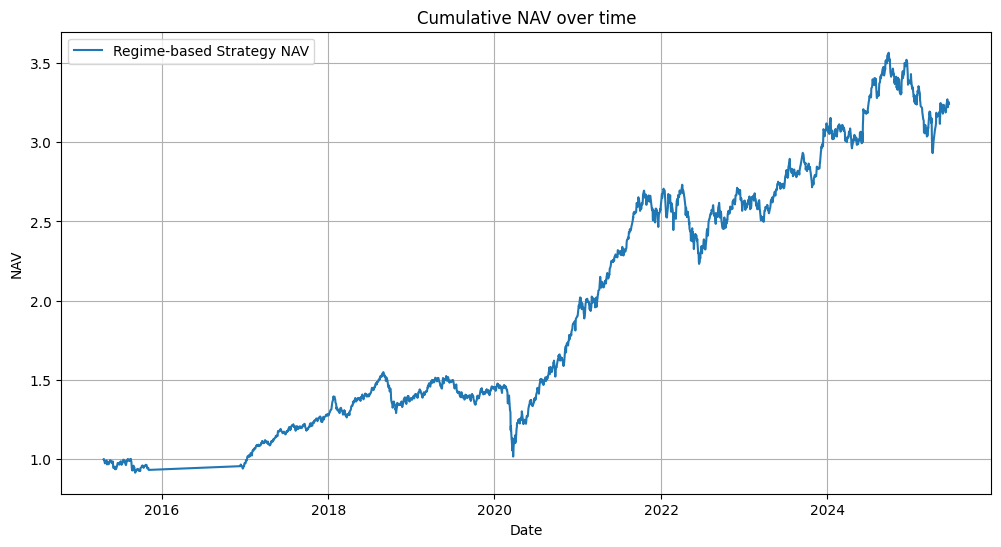

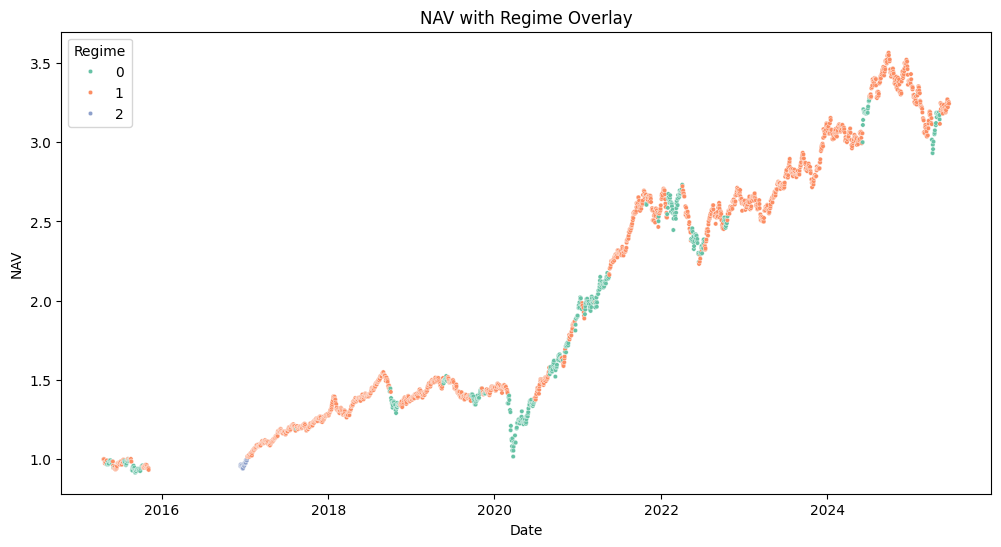

In [7]:
# -------------------------------------------
# Step 6: Plots
# -------------------------------------------
plt.figure(figsize=(12,6))
plt.plot(data.index, data['cum_nav'], label='Regime-based Strategy NAV')
plt.title("Cumulative NAV over time")
plt.xlabel("Date")
plt.ylabel("NAV")
plt.legend()
plt.grid(True)
plt.show()

# Overlay regime bands
plt.figure(figsize=(12,6))
sns.scatterplot(x=data.index, y=data['cum_nav'], hue=data['cluster_regime'], palette='Set2', s=10)
plt.title("NAV with Regime Overlay")
plt.xlabel("Date")
plt.ylabel("NAV")
plt.legend(title='Regime')
plt.show()